In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd 
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader
from livelossplot import PlotLosses

In [2]:
apple_df = pd.read_csv('AAPL.csv')

In [3]:
last_10_percent = int(len(apple_df) * 0.1)
apple_df= apple_df[-last_10_percent:]

In [4]:
apple_df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
8919,2016-04-27,96.000000,98.709999,95.680000,97.820000,91.688515,114602100
8920,2016-04-28,97.610001,97.879997,94.250000,94.830002,88.885933,82242700
8921,2016-04-29,93.989998,94.720001,92.510002,93.739998,87.864235,68531500
8922,2016-05-02,93.970001,94.080002,92.400002,93.639999,87.770515,48160100
8923,2016-05-03,94.199997,95.739998,93.680000,95.180000,89.213974,56831300


In [5]:
apple_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,990.000000,990.000000,990.000000,990.000000,990.000000,9.900000e+02
mean,176.101081,177.825586,174.572111,176.289303,172.253467,3.208369e+07
std,52.152245,53.005754,51.506245,52.336505,53.877821,1.510742e+07
min,90.000000,91.669998,89.470001,90.339996,85.192909,1.136200e+07
25%,143.682495,144.345001,142.899994,143.660004,137.525784,2.216532e+07
50%,172.489998,174.059998,171.149994,172.470001,168.073662,2.771435e+07
75%,204.097504,205.999996,202.572498,204.382504,202.099899,3.653068e+07
max,324.739990,327.850006,323.350006,327.200012,327.200012,1.146021e+08


In [6]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 8919 to 9908
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       990 non-null    object 
 1   Open       990 non-null    float64
 2   High       990 non-null    float64
 3   Low        990 non-null    float64
 4   Close      990 non-null    float64
 5   Adj Close  990 non-null    float64
 6   Volume     990 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 54.3+ KB


In [7]:
#Convert Date column to datetime and set as index
apple_df['Date'] = pd.to_datetime(apple_df['Date'])
apple_df.set_index("Date", inplace=True)

In [8]:
def plot_closing_price(df, feature, name):
    df.plot(y=feature, ylabel="Closing Price $", title=f"{name} {feature} Stock History", legend=None)

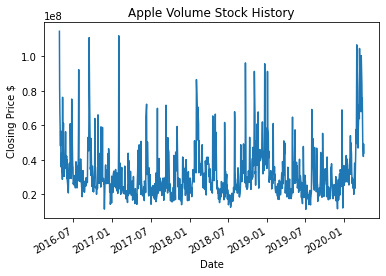

In [9]:
plot_closing_price(apple_df, "Volume", "Apple")

In [10]:
moving_averages = [10, 20, 30]

In [11]:
def plot_closing_price_with_moving_averages(df, name, years, moving_averages):
    # Find the last date entry in the DataFrame
    last_date_entry = df.index[-1]

    # Calculate the starting date for the last three years
    start_date = last_date_entry - pd.DateOffset(years=years)

    # Filter data for the last three years
    df_last_three_years = df[df.index >= start_date]

    # Calculate moving averages
    for moving_average in moving_averages:
        col_name = f"MA for {moving_average} days"
        df_last_three_years[col_name] = df_last_three_years['Adj Close'].rolling(moving_average).mean()
    
    # Plot adjusted close prices
    df_last_three_years['Adj Close'].plot(label='Adj Close')
    
    # Plot moving averages
    for moving_average in moving_averages:
        col_name = f"MA for {moving_average} days"
        df_last_three_years[col_name].plot(label=col_name)

    plt.xlabel("Date")
    plt.ylabel("Price $")
    plt.title(f"Closing Price and Moving Averages of {name}")
    plt.legend()


/home/crasious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


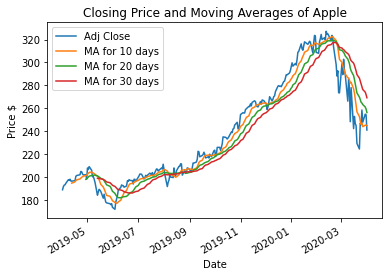

In [12]:
plot_closing_price_with_moving_averages(apple_df, "Apple", 1, moving_averages)

In [13]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [14]:
apple_df['Close'] = scaler.fit_transform(apple_df['Close'].values.reshape(-1, 1))

In [15]:
apple_df['Close']

Date
2016-04-27   -0.936840
2016-04-28   -0.962087
2016-04-29   -0.971291
2016-05-02   -0.972135
2016-05-03   -0.959132
                ...   
2020-03-26    0.419404
2020-03-27    0.329055
2020-03-30    0.388753
2020-03-31    0.384362
2020-04-01    0.271384
Name: Close, Length: 990, dtype: float64

In [16]:
apple_df= apple_df[['Close']]

In [17]:
sequence_length = 60

In [18]:
def load_data(stock, look_back, batch_size=4):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]
    
    return x_train, y_train, x_test, y_test

In [19]:
x_train, y_train, x_test, y_test = load_data(apple_df, sequence_length)

In [20]:
# Convert numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

In [21]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
lr = 0.01
epochs = 100
criterion = nn.MSELoss()
batch_size = 16

In [22]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
def train(model, optimiser, criterion, dataloader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in dataloader:
        y_pred = model(X)
        loss = criterion(y_pred, y)
        optimiser.zero_grad()
        loss.backward()
        train_loss += loss * X.size(0)
        train_accuracy += np.sqrt(mean_squared_error(y.detach().numpy(), y_pred.detach().numpy()))
        optimiser.step()
    
    return train_loss / len(dataloader.dataset), train_accuracy / len(dataloader.dataset)

In [24]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out



model = LSTM(input_dim, hidden_dim, num_layers, output_dim)
optimiser = torch.optim.Adam(model.parameters(), lr=lr)

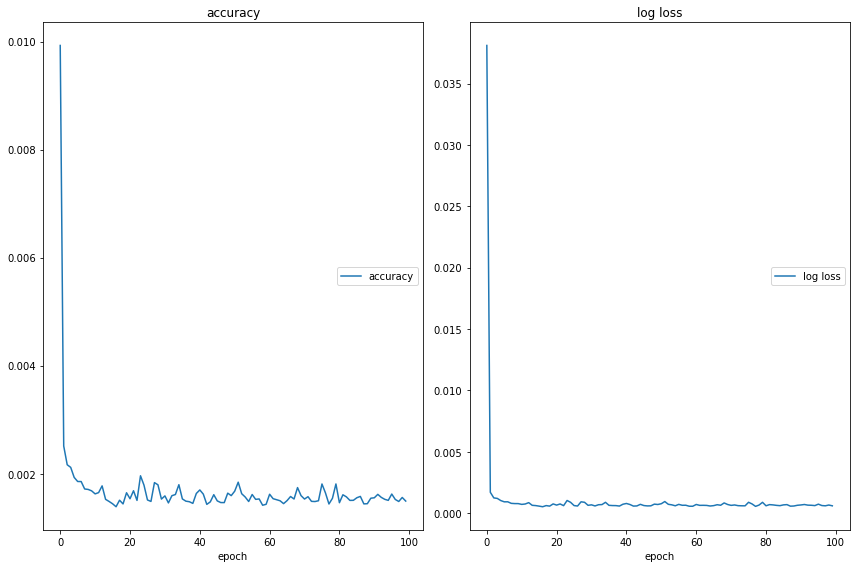

accuracy
	accuracy         	 (min:    0.001, max:    0.010, cur:    0.001)
log loss
	log loss         	 (min:    0.001, max:    0.038, cur:    0.001)


In [25]:
liveloss = PlotLosses()
for epoch in range(epochs):
      logs = {}
      train_loss, train_accuracy = train(model, optimiser, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      
      logs['' + 'accuracy'] = train_accuracy.item()
    
      liveloss.update(logs)
      liveloss.draw()

In [26]:
y_test_pred = model(x_test_tensor)

In [27]:
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test)

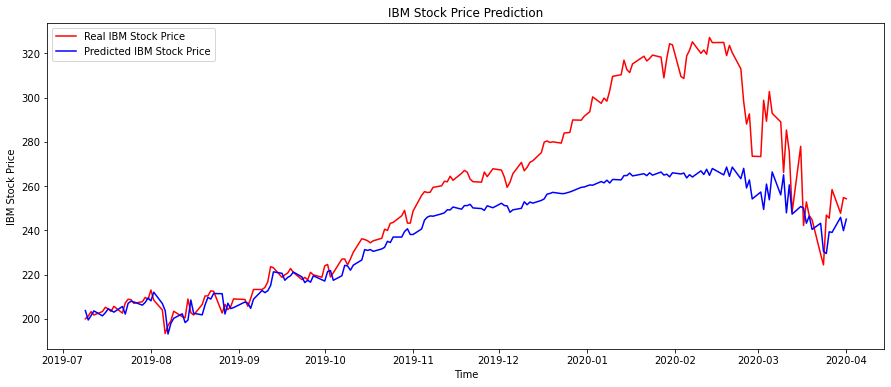

In [28]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(apple_df[len(apple_df)-len(y_test):].index, y_test, color = 'red', label = 'Real IBM Stock Price')
axes.plot(apple_df[len(apple_df)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted IBM Stock Price')

plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.savefig('ibm_pred.png')
plt.show()